In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch Requirements
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

%matplotlib inline

This notebook is complementary to the VAE_with_preprocessing notebook to demonstrate the importance of data preprocessing prior to training generative AI models. In VAE_with_preprocessing, it can be seen that the training was quick and the reconstructed samples nearly identical, although some fine tuning will help. In this notebook, due to the scale of the raw spectral data, a much larger concentrated effort is required to design a model capable of reproducing the data. The end product in this work is not finalised, but it serves to show how much extra variation is introduced to the design and training phases.

We present some key points to consider.

Loss function:
* MSELoss Reduction - When applying an MSELoss we must decide to calculate the reconstruction loss average per batch or per sample. This will have a large effect if batch sizes are uneven or variability in the data is large, consider the size difference between some samples with peaks maxing at 10,000 vs 50,000 count rates for example. This is likely due to the variance in the reconstruction loss being diminished when averaged over a large number of elements vs the batch size.

* Batch Size and Hyperparameter Sensitivity - Depending on the selection above, tuning of the batch size, learning rate, and optimisation parameters are more sensitive. Larger batches result in larger errors, but typically more stable training because gradient averaging over more samples reduces noise. On the other hand, lower batch sizes allow more contribution from the samples to learning but can be noisy and hard to interpret.

* Custom Loss Function - A custom loss such as Mean Absolute Error may provide a middle ground due its linear sensitivity to outliers compared to MSE's quadratic scaling.


Latent Space:
* KL Annealing - If we reduce by "mean", i.e., per element in the MSELoss, the KL loss may dominate the reconstruction loss due to its diminishing gradients. A KL annealing effect may help mitigate this, but the issue will still persist at loss errors on this scale. Other annealing effects could be considered, such as KL annealing via sigmoid.
  
* Clamping Log Variance: Due to the scale of the data we need to "clamp" or "clip" the log variance in the latent space to prevent instability during training. Without clamping or clipping, the exponential of the log variance becomes too large and approaches infinity. Resulting in an "inf" or "NaN" loss and no updates being performed. See the Encoder objects forward() function.
  
* Consequences of Clamping - Clamping may prevent instability, but it results in information loss. Specifically, the KL loss will begin to approach zero but the reconstruction loss may fail to minimise.
  
* Clamping Observation - Clamping to roughly 20 was found to be the best middle ground, but results in synthetic spectra generated with lower magnitudes.


Weights and Gradients:
* Weight Initialisation - At the beginning, consider trying different weighting schemes to control the randomness, such as Xavier, Glorot, or He for example.

* Gradient Clipping - If the gradients are growing to large, they can be clipped using their norm. L2 is norm is common, and default in PyTorch.
  
* Learning Rate Scheduler - Apply a scheduler to decrease the learning rate over the epochs as the training progresses and the model begins to converge.



In [2]:
# Load and prepare data
data = pd.read_csv("../../data/cyclohexane.csv", header=0)

# raw data and best sample
X = data.drop("solvent", axis=1)
best_sample = X.iloc[0].to_numpy().reshape(-1, 1)

## Visualise raw data

In [3]:
plt.rcParams['font.size'] = 12
xticks = np.linspace(0, X.shape[1]-1, 10, dtype=int)
xlabels = X.columns[xticks].astype(float).astype(int).values

def build_plot():
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.ylabel("Intensity (a.u)")
    plt.xlabel("Raman Shift (cm$^{-1}$)")
    plt.xlim([-20, 3296])
    plt.xticks(xticks, labels=xlabels)
    plt.grid(False)
    
    return fig

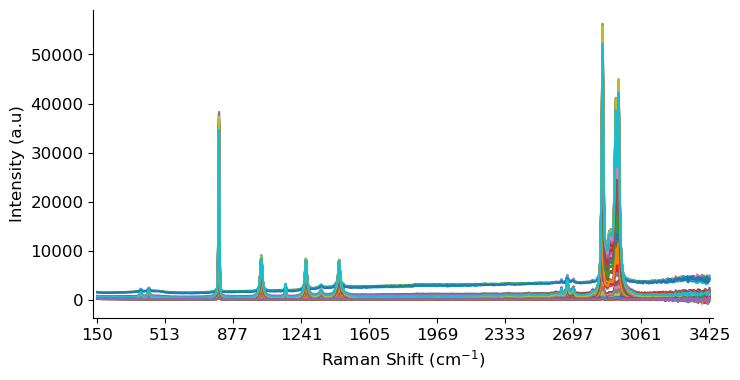

In [4]:
# Raw Spectra
_ = build_plot()
plt.plot(X.T);

## Define required functions

In [5]:
# First we need a custom Torch tensor Dataset to load in the data
class CyclohexaneDataTensor(Dataset):
    def __init__(self, data_X: Tensor, transform_list=None):
        """
        Initialises object and performs data transformation if desired
        
        Args:
            data_X (array-like):
                Spectral data matrix (NumPy array or PyTorch Tensor).
            transform_list (list):
                List of transformations to apply to data (e.g., normalizing, scaling).

        """
        if not isinstance(data_X, (np.ndarray, Tensor)):
            raise TypeError("data_X must be a NumPy array or PyTorch tensor")
            
        self.X_tensor = torch.as_tensor(data_X, dtype=torch.float32)
        self.transforms = transform_list

    def __getitem__(self, index) -> Tensor:
        x = self.X_tensor[index].clone()

        if self.transforms:
            for transform in self.transforms:
                x = transform(x)
        return x

    def __len__(self) -> int:
        return self.X_tensor.size(0)

# define a function to specify how we want the weights to initialise
def init_weights(model: nn.Module):
    if isinstance(model, nn.Linear):
        torch.nn.init.kaiming_normal_(model.weight)
        model.bias.data.fill_(0.01)

# Define our loss as the reconstruction loss (MSE) + the kullback-leibler (KL) Divergence
def loss_function(x: Tensor, x_hat: Tensor, mean: Tensor, logvar: Tensor, current_step, total_steps) -> Tensor:
    """
    Computes the loss for the Variational Autoencoder (VAE).

    Args:
        x (Tensor): 
            Original input data.
        x_hat (Tensor): 
            Reconstructed data.
        mean (Tensor): 
            Mean from the encoder's latent distribution.
        logvar (Tensor): 
            Log-variance from the encoder's latent distribution.

    Returns:
        Tensor: 
            Total VAE loss (reconstruction + KL divergence).
    """
    
    # Reconstruction loss
    # Use this when you want the average loss per sample in the batch, use reduction='mean' for per element loss
    reconstruction_loss = nn.MSELoss(reduction="sum")(x_hat, x) / x.size(0) # normalise by the batch size for stability during training
        
    # If KL loss dominates the reconstruction loss, consider KL annealing (this is linear)
    #annealing_factor = min(1.0, current_step / total_steps) 

    # KL Divergence: KL(Q(mean, log variance) || N(0, 1))
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp() + 1e-8) / x.size(0) # Add a small constant to the variance to avoid log(0)
    #kl_divergence = annealing_factor * kl_divergence
    
    total_loss = (reconstruction_loss + kl_divergence)
    return total_loss, reconstruction_loss, kl_divergence

# function to visualise samples as the model trains and progresses
def draw_synthetic_sample(model: nn.Module, epoch: int, sample_shape: int):
    """
    Function that takes in the decoder, generates a sample and plots it.

    Args:
        model (nn.Module):
            Generator model.
        epoch (int):
            current epoch in training.
        noise_input (array-like):
            initial noise to feed forward
    """
    model.eval()

    # `detach` to remove from graph and no gradients computed
    noise = torch.randn(4, LATENT_DIM, device=DEVICE).detach()
    z_samples = model(noise).detach().cpu() # move to CPU for visualisation

    # loop N samples
    for i in range(z_samples.size(0)):
        plt.figure()
        plt.plot(z_samples[i].numpy().reshape(sample_shape))
        plt.show()

In [6]:
# Define separate models so we can save the decoder and discard the encoder later
class Encoder(nn.Module):
    """
    Encoder for mapping 1D Raman signals to latent space
    """
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        
        # Define the layers of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2000),
            nn.ReLU(),
            nn.Linear(2000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU()
        )
        
        # Latent space layers: mean and log variance
        self.mean_layer = nn.Linear(500, latent_dim)        
        self.logvar_layer = nn.Linear(500, latent_dim)

    def forward(self, x):
        # Pass input through encoder layers
        x = self.encoder(x)
        
        # Calculate mean and log variance for the latent space
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)

        # clamp the latent space to stop it exploding
        logvar = torch.clamp(logvar, max=20)
        
        return mean, logvar

class Decoder(nn.Module):
    """
    Decoder for sampling latent space and reconstructing 1D Raman signals
    """
    def __init__(self, latent_dim, input_dim):
        super(Decoder, self).__init__()
        
        # Define the layers of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 2000),
            nn.ReLU(),
            nn.Linear(2000, input_dim),

            # At this point we would add an output function like sigmoid if our data was scaled between 0-1
            # or it is more numerically stable to train from logits using a loss that incorporates the function
            # see BCELoss vs BCEWithLogitsLoss
        )

    def forward(self, z):
        # Pass the latent variable through the decoder layers
        x_hat = self.decoder(z)
        return x_hat

# Define a symmetrical VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, device):
        super(VAE, self).__init__()

        self.device = device

        # Initialize encoder and decoder
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        x = x.to(self.device)
        
        # Encoder: obtain the mean and log variance of the latent space
        mean, logvar = self.encoder(x)

        # Reparameterisation trick: sample from the latent space (z = μ + σ ⊙ ε)
        epsilon = torch.randn_like(logvar).to(self.device)
        z = mean + torch.exp(0.5 * logvar) * epsilon

        # Decoder: reconstruct the input
        x_hat = self.decoder(z)

        return x_hat, mean, logvar

## Constants, hyperparameters and training loop

In [7]:
# Constants and hyperparameters
EPOCHS: int = 5000
BATCH_SIZE: int = 32
LATENT_DIM: int = 50
SAMPLE_SHAPE: int = X.shape[1]
LEARNING_RATE: float = 0.01
BETA_1: float = 0.9
BETA_2: float = 0.99
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

# Configure data in Torch Dataset for training
X_copy = X.copy().to_numpy()
X_train = CyclohexaneDataTensor(X_copy)
train_loader = DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# define the model
model = VAE(SAMPLE_SHAPE, LATENT_DIM, DEVICE).to(DEVICE)
#model.apply(init_weights)

model.train() # tell Torch we are going to start training

# Load our optimiser
optimiser = Adam(model.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))

Training on cuda:0


Epoch:[1/5000] 	Average Epoch Loss: 44357174715326872.0000 	Recon Loss: 44355550415883880.0000 	KL Loss: 1624581302348.8000
Epoch:[2/5000] 	Average Epoch Loss: 811017322496.0000 	Recon Loss: 573293144473.6000 	KL Loss: 237724162457.6000
Epoch:[3/5000] 	Average Epoch Loss: 3746888823603.2002 	Recon Loss: 589501117235.2000 	KL Loss: 3157387640832.0000
Epoch:[4/5000] 	Average Epoch Loss: 2314167969382.3999 	Recon Loss: 65441995366.4000 	KL Loss: 2248725966028.7998
Epoch:[5/5000] 	Average Epoch Loss: 574296879104.0000 	Recon Loss: 396168539750.4000 	KL Loss: 178128339353.6000
Epoch:[6/5000] 	Average Epoch Loss: 223817686220.8000 	Recon Loss: 85110957875.2000 	KL Loss: 138706733465.6000
Epoch:[7/5000] 	Average Epoch Loss: 77229702758.4000 	Recon Loss: 53962733363.2000 	KL Loss: 23266968371.2000
Epoch:[8/5000] 	Average Epoch Loss: 42099181977.6000 	Recon Loss: 21081260032.0000 	KL Loss: 21017922560.0000
Epoch:[9/5000] 	Average Epoch Loss: 466633557606.4000 	Recon Loss: 304941306265.6000 	KL 

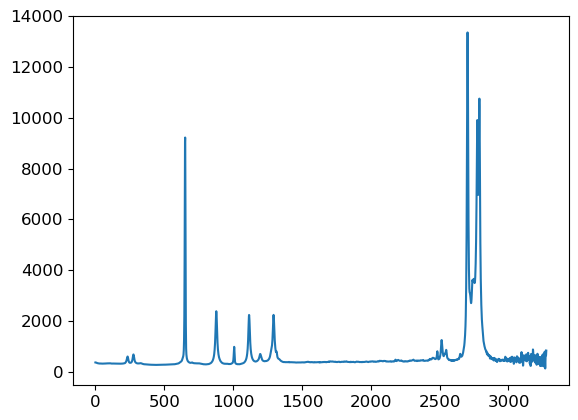

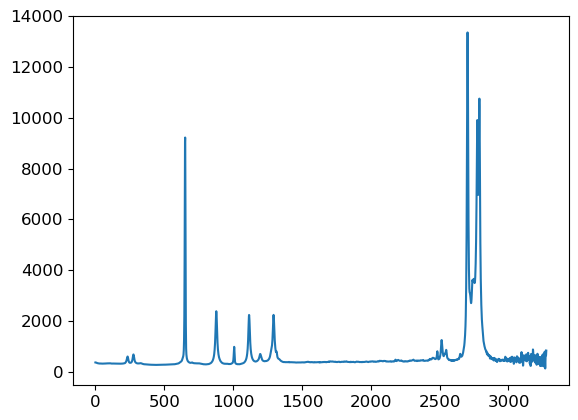

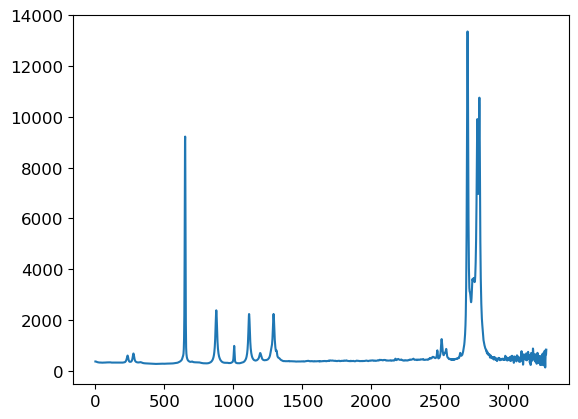

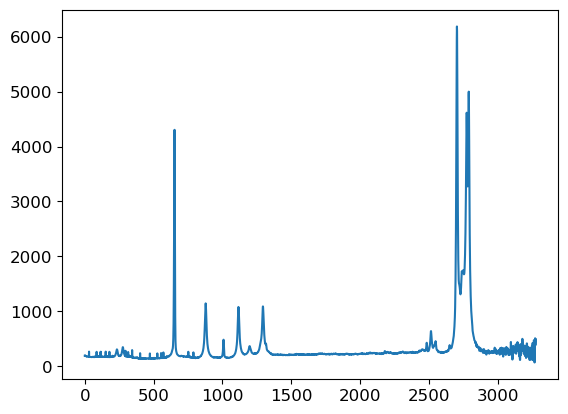

Epoch:[1001/5000] 	Average Epoch Loss: 11929591193.6000 	Recon Loss: 11929591193.6000 	KL Loss: 25.0406
Epoch:[1002/5000] 	Average Epoch Loss: 11125519155.2000 	Recon Loss: 11125519155.2000 	KL Loss: 25.0406
Epoch:[1003/5000] 	Average Epoch Loss: 11381472256.0000 	Recon Loss: 11381472256.0000 	KL Loss: 25.0407
Epoch:[1004/5000] 	Average Epoch Loss: 11498785177.6000 	Recon Loss: 11498785177.6000 	KL Loss: 25.0407
Epoch:[1005/5000] 	Average Epoch Loss: 11404938649.6000 	Recon Loss: 11404938649.6000 	KL Loss: 25.0407
Epoch:[1006/5000] 	Average Epoch Loss: 11058373222.4000 	Recon Loss: 11058373222.4000 	KL Loss: 25.0407
Epoch:[1007/5000] 	Average Epoch Loss: 11223152230.4000 	Recon Loss: 11223152230.4000 	KL Loss: 25.0407
Epoch:[1008/5000] 	Average Epoch Loss: 11669191065.6000 	Recon Loss: 11669191065.6000 	KL Loss: 25.0407
Epoch:[1009/5000] 	Average Epoch Loss: 11319559987.2000 	Recon Loss: 11319559987.2000 	KL Loss: 25.0407
Epoch:[1010/5000] 	Average Epoch Loss: 11317928140.8000 	Recon L

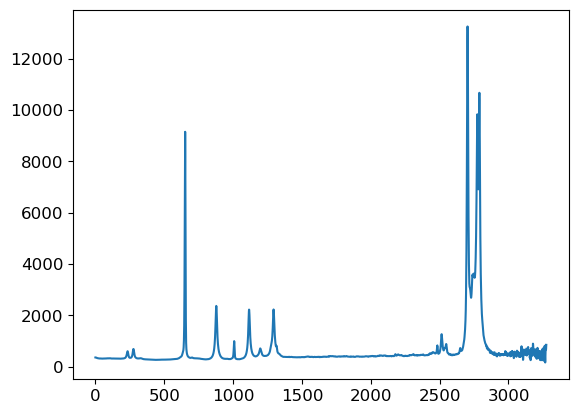

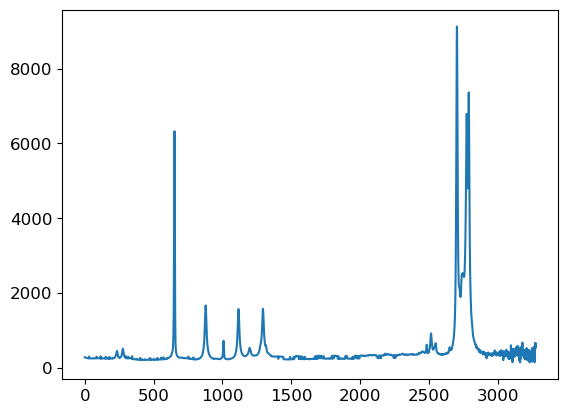

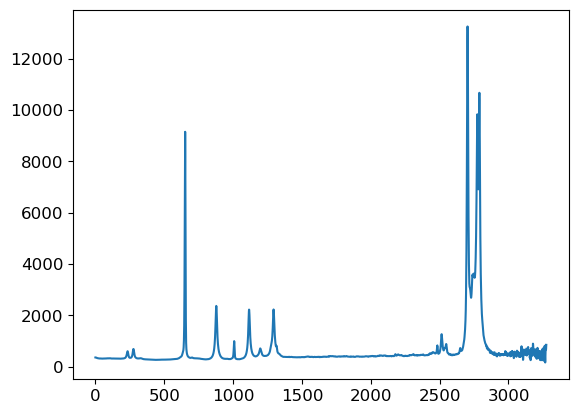

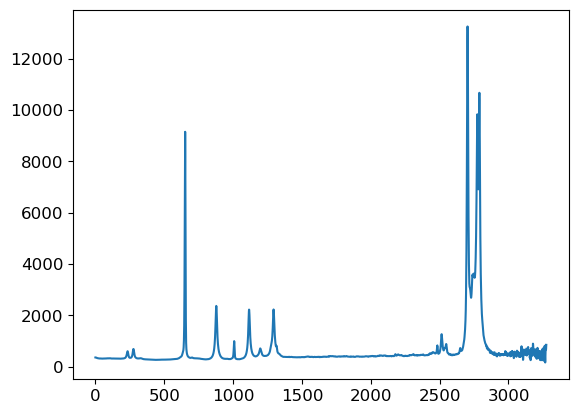

Epoch:[2001/5000] 	Average Epoch Loss: 11555895296.0000 	Recon Loss: 11555895296.0000 	KL Loss: 7.8862
Epoch:[2002/5000] 	Average Epoch Loss: 11305404211.2000 	Recon Loss: 11305404211.2000 	KL Loss: 8.7156
Epoch:[2003/5000] 	Average Epoch Loss: 11235307212.8000 	Recon Loss: 11235307212.8000 	KL Loss: 10.6609
Epoch:[2004/5000] 	Average Epoch Loss: 11832861491.2000 	Recon Loss: 11832861491.2000 	KL Loss: 12.0672
Epoch:[2005/5000] 	Average Epoch Loss: 11812706508.8000 	Recon Loss: 11812706508.8000 	KL Loss: 13.0102
Epoch:[2006/5000] 	Average Epoch Loss: 11453328384.0000 	Recon Loss: 11453328384.0000 	KL Loss: 13.6165
Epoch:[2007/5000] 	Average Epoch Loss: 11657311129.6000 	Recon Loss: 11657311129.6000 	KL Loss: 13.9967
Epoch:[2008/5000] 	Average Epoch Loss: 11750292787.2000 	Recon Loss: 11750292787.2000 	KL Loss: 14.2315
Epoch:[2009/5000] 	Average Epoch Loss: 11177465344.0000 	Recon Loss: 11177465344.0000 	KL Loss: 14.3753
Epoch:[2010/5000] 	Average Epoch Loss: 11726376345.6000 	Recon Los

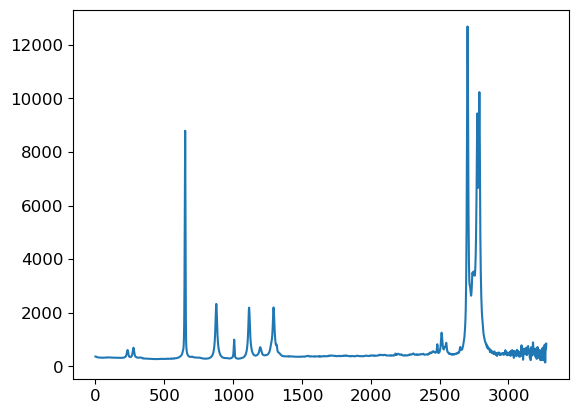

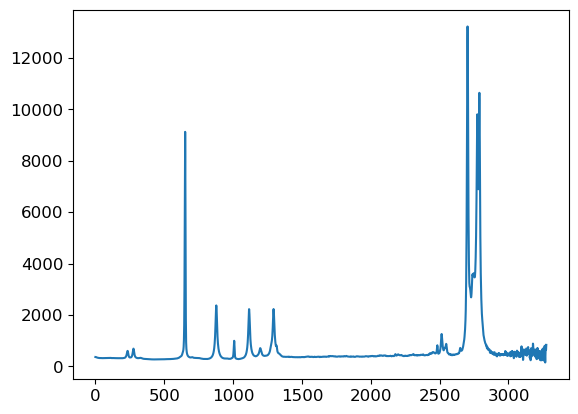

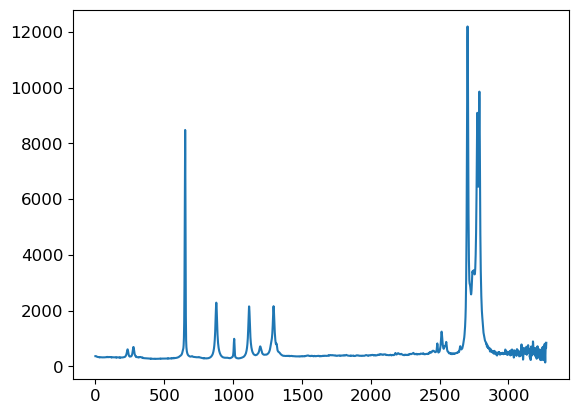

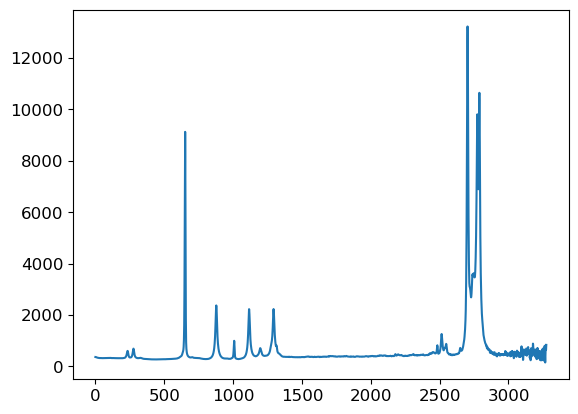

Epoch:[3001/5000] 	Average Epoch Loss: 11065101824.0000 	Recon Loss: 11065101824.0000 	KL Loss: 25.3446
Epoch:[3002/5000] 	Average Epoch Loss: 11270874316.8000 	Recon Loss: 11270874316.8000 	KL Loss: 25.3385
Epoch:[3003/5000] 	Average Epoch Loss: 11364080947.2000 	Recon Loss: 11364080947.2000 	KL Loss: 25.3323
Epoch:[3004/5000] 	Average Epoch Loss: 11400054374.4000 	Recon Loss: 11400054374.4000 	KL Loss: 25.3259
Epoch:[3005/5000] 	Average Epoch Loss: 11931762688.0000 	Recon Loss: 11931762688.0000 	KL Loss: 25.3194
Epoch:[3006/5000] 	Average Epoch Loss: 11528045363.2000 	Recon Loss: 11528045363.2000 	KL Loss: 25.3127
Epoch:[3007/5000] 	Average Epoch Loss: 11962707353.6000 	Recon Loss: 11962707353.6000 	KL Loss: 25.3059
Epoch:[3008/5000] 	Average Epoch Loss: 11448523366.4000 	Recon Loss: 11448523366.4000 	KL Loss: 25.2989
Epoch:[3009/5000] 	Average Epoch Loss: 12105334681.6000 	Recon Loss: 12105334681.6000 	KL Loss: 25.2918
Epoch:[3010/5000] 	Average Epoch Loss: 11413633638.4000 	Recon L

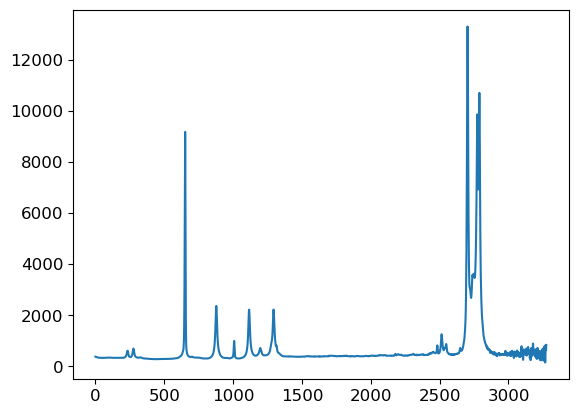

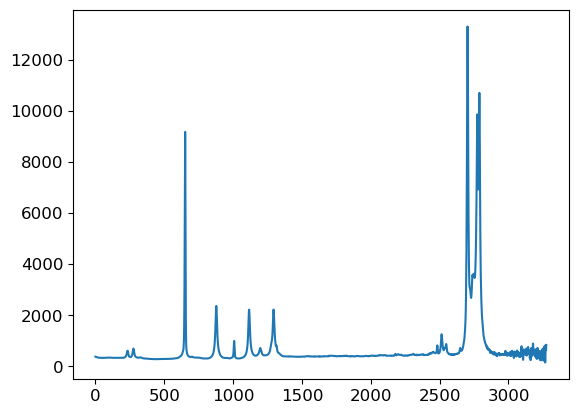

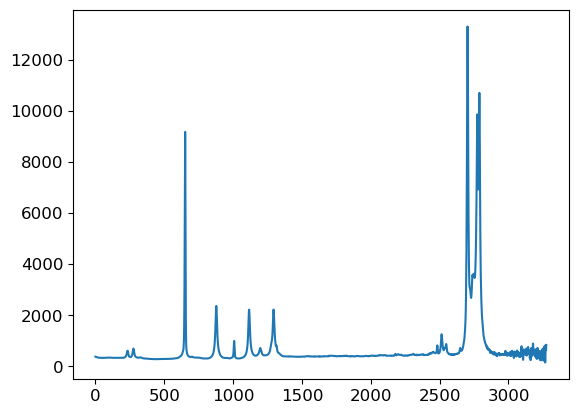

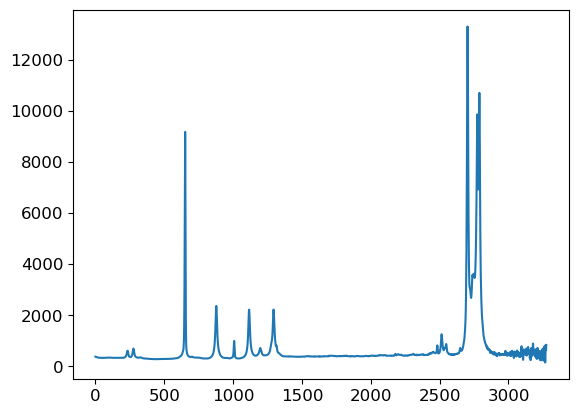

Epoch:[4001/5000] 	Average Epoch Loss: 11852723200.0000 	Recon Loss: 11852723200.0000 	KL Loss: 18.2347
Epoch:[4002/5000] 	Average Epoch Loss: 12363189964.8000 	Recon Loss: 12363189964.8000 	KL Loss: 18.2333
Epoch:[4003/5000] 	Average Epoch Loss: 12115486310.4000 	Recon Loss: 12115486310.4000 	KL Loss: 18.2319
Epoch:[4004/5000] 	Average Epoch Loss: 11196958822.4000 	Recon Loss: 11196958822.4000 	KL Loss: 18.2305
Epoch:[4005/5000] 	Average Epoch Loss: 11275858534.4000 	Recon Loss: 11275858534.4000 	KL Loss: 18.2290
Epoch:[4006/5000] 	Average Epoch Loss: 11510666444.8000 	Recon Loss: 11510666444.8000 	KL Loss: 18.2275
Epoch:[4007/5000] 	Average Epoch Loss: 11618244403.2000 	Recon Loss: 11618244403.2000 	KL Loss: 18.2260
Epoch:[4008/5000] 	Average Epoch Loss: 11637644288.0000 	Recon Loss: 11637644288.0000 	KL Loss: 18.2245
Epoch:[4009/5000] 	Average Epoch Loss: 11491178086.4000 	Recon Loss: 11491178086.4000 	KL Loss: 18.2229
Epoch:[4010/5000] 	Average Epoch Loss: 12038026854.4000 	Recon L

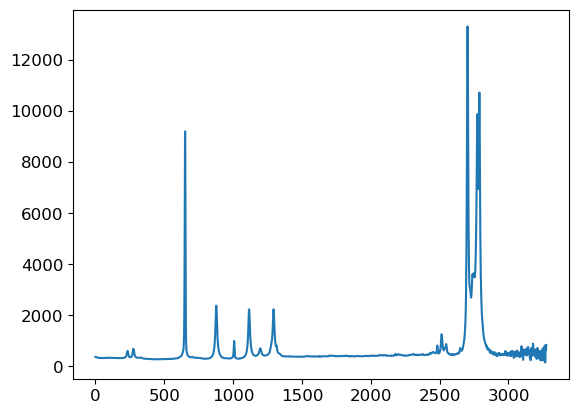

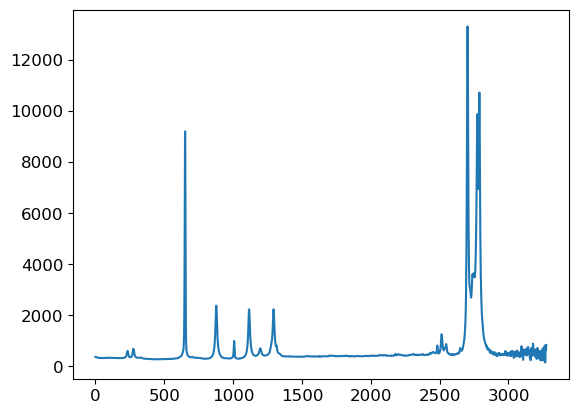

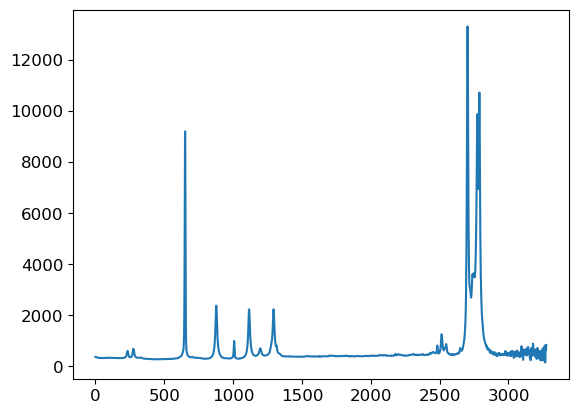

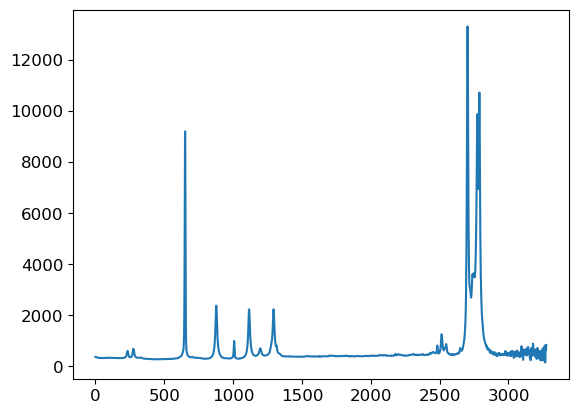

VAE training took approx: 1.7639 minutes


In [8]:
# track training time
start_time = time.time()

average_epoch_losses = []

# for KL annealing
step = 0
total_steps = len(train_loader) * EPOCHS

# Define training loop
for epoch in range(EPOCHS):
    
    epoch_loss = 0
    recon_loss = 0
    kl_loss = 0
    
    for batch_idx, batch in enumerate(train_loader):
        batch = batch.to(DEVICE)
        
        # reset optimiser each iteration
        optimiser.zero_grad() 

        # feed sample and reconstruct
        x_hat, mean, logvar = model(batch)
       
        loss, reconstruction_loss, kl_divergence = loss_function(batch, x_hat, mean, logvar, step, total_steps)
        step += 1
 
        # track loss for each iteration
        epoch_loss += loss.item()
        recon_loss += reconstruction_loss.item()
        kl_loss += kl_divergence.item()
        
        # calculate gradients and update model
        loss.backward()

        # For checking the gradients
        # print("Gradients:")
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f"{name}: {param.grad}")
        #     else:
        #         print(f"{name}: No gradient computed")

        # clipping gradients
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Perform update
        optimiser.step()
        
    # Training stats  
    average_epoch_loss = epoch_loss / len(train_loader)
    average_recon_loss = recon_loss / len(train_loader)
    average_kl_loss = kl_loss / len(train_loader)
    print(f'Epoch:[{epoch + 1}/{EPOCHS}] \tAverage Epoch Loss: {average_epoch_loss:.4f} \tRecon Loss: {average_recon_loss:.4f} \tKL Loss: {average_kl_loss:.4f}')

    average_epoch_losses.append(average_epoch_loss)
    
    # Draw some samples
    if (epoch + 1) % 1000 == 0:
        draw_synthetic_sample(model.decoder, epoch + 1, SAMPLE_SHAPE)
        model.train() # required again if we execute eval() to visualise samples during training

print(f"VAE training took approx: {round((time.time() - start_time) / 60, 4)} minutes")

# Plot losses

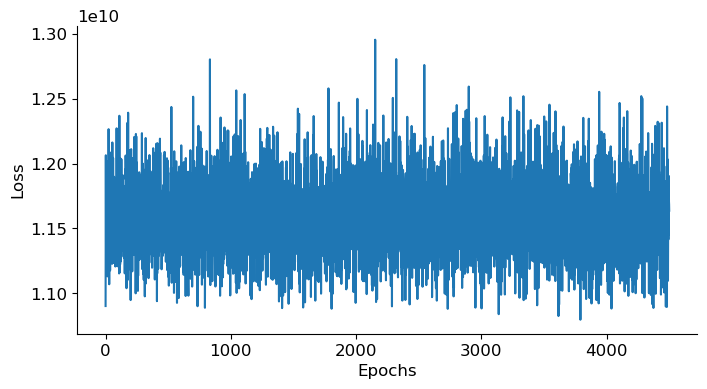

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid(False)

# first few epochs are very large, let's ignore for now
plt.plot(average_epoch_losses[500:]);

# Save model to disk

In [10]:
decoder_path = "models/vae_decoder_raw.pth"
torch.save(model.decoder.state_dict(), decoder_path)

# Load model from disk

In [11]:
# define new model
decoder = Decoder(LATENT_DIM, SAMPLE_SHAPE)

# Load the saved weights
decoder.load_state_dict(torch.load(decoder_path))
decoder.to(DEVICE)
decoder.eval()

# Generate some samples
noise = torch.randn(145, LATENT_DIM, device=DEVICE).detach()
synthetic_samples = decoder(noise).detach().cpu().numpy()

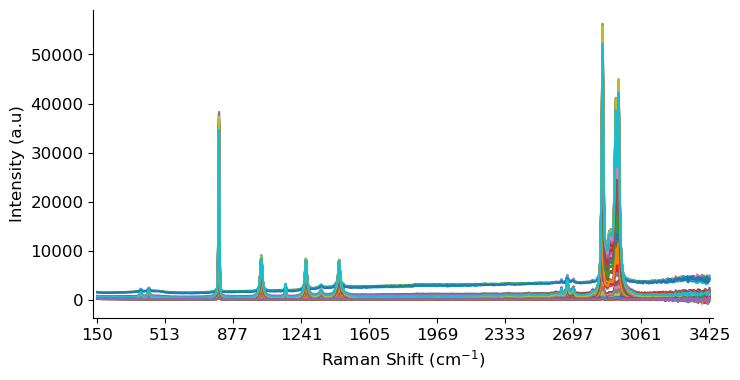

In [12]:
# Original spectra
_ = build_plot()
plt.plot(X.T);

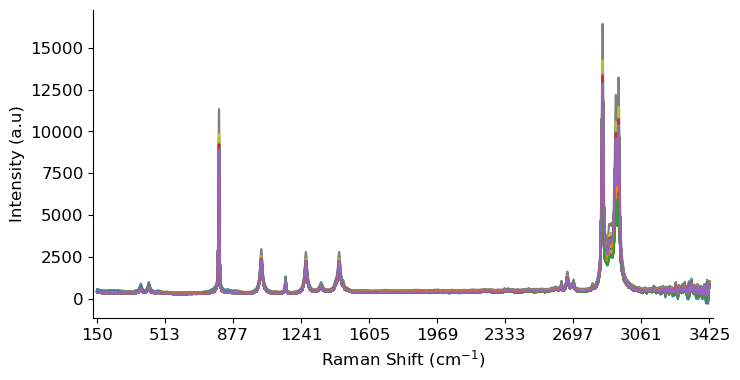

In [13]:
# New Synthetic spectra
_ = build_plot()
plt.plot(synthetic_samples.T);